In [1]:
import re
import sys
import yaml
import torch
import torchvision
from tqdm import tqdm
from warp_core.utils import load_or_fail

sys.path.append("..")
from utils import *
from train import WurstCoreB

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [22]:
!wget https://huggingface.co/dome272/wuerstchen/resolve/main/vqgan_f4_v1_500k.pt -P models/

--2024-02-06 19:09:13--  https://huggingface.co/dome272/wuerstchen/resolve/main/vqgan_f4_v1_500k.pt
Resolving huggingface.co (huggingface.co)... 99.84.66.112, 99.84.66.72, 99.84.66.70, ...
Connecting to huggingface.co (huggingface.co)|99.84.66.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/b9/6e/b96ebc9f17a640b8e89f419a072a1ef4e6dadbcdf69a668bf2518fc87cd52c63/b4a81dd8733268a68d08844e33b917d4dbe27d5c5382dcbde522df3af16f343e?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27vqgan_f4_v1_500k.pt%3B+filename%3D%22vqgan_f4_v1_500k.pt%22%3B&Expires=1707505753&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcwNzUwNTc1M319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy9iOS82ZS9iOTZlYmM5ZjE3YTY0MGI4ZTg5ZjQxOWEwNzJhMWVmNGU2ZGFkYmNkZjY5YTY2OGJmMjUxOGZjODdjZDUyYzYzL2I0YTgxZGQ4NzMzMjY4YTY4ZDA4ODQ0ZTMzYjkxN2Q0ZGJlMjdkNWM1MzgyZGNiZGU1MjJkZjNhZjE2ZjM0M2U%7

In [2]:
# SETUP STAGE B & A
config_file_b = '../configs/inference/stage_b_3b.yaml'
with open(config_file_b, "r", encoding="utf-8") as file:
    config_file_b = yaml.safe_load(file)
    
core = WurstCoreB(config_dict=config_file_b, device=device, training=False)

['model_version', 'stage_a_checkpoint_path', 'effnet_checkpoint_path']


In [3]:
extras = core.setup_extras_pre()
data = core.setup_data(extras)
models = core.setup_models(extras)
models.generator.bfloat16()
print("STAGE B READY")

['transforms', 'clip_preprocess', 'gdf', 'sampling_configs', 'effnet_preprocess']
Training with batch size 4 (4/GPU)
['dataset', 'dataloader', 'iterator']


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

['tokenizer', 'text_model', 'generator', 'effnet', 'stage_a']
STAGE B READY


ORIG SIZE: torch.Size([4, 3, 1024, 1024])


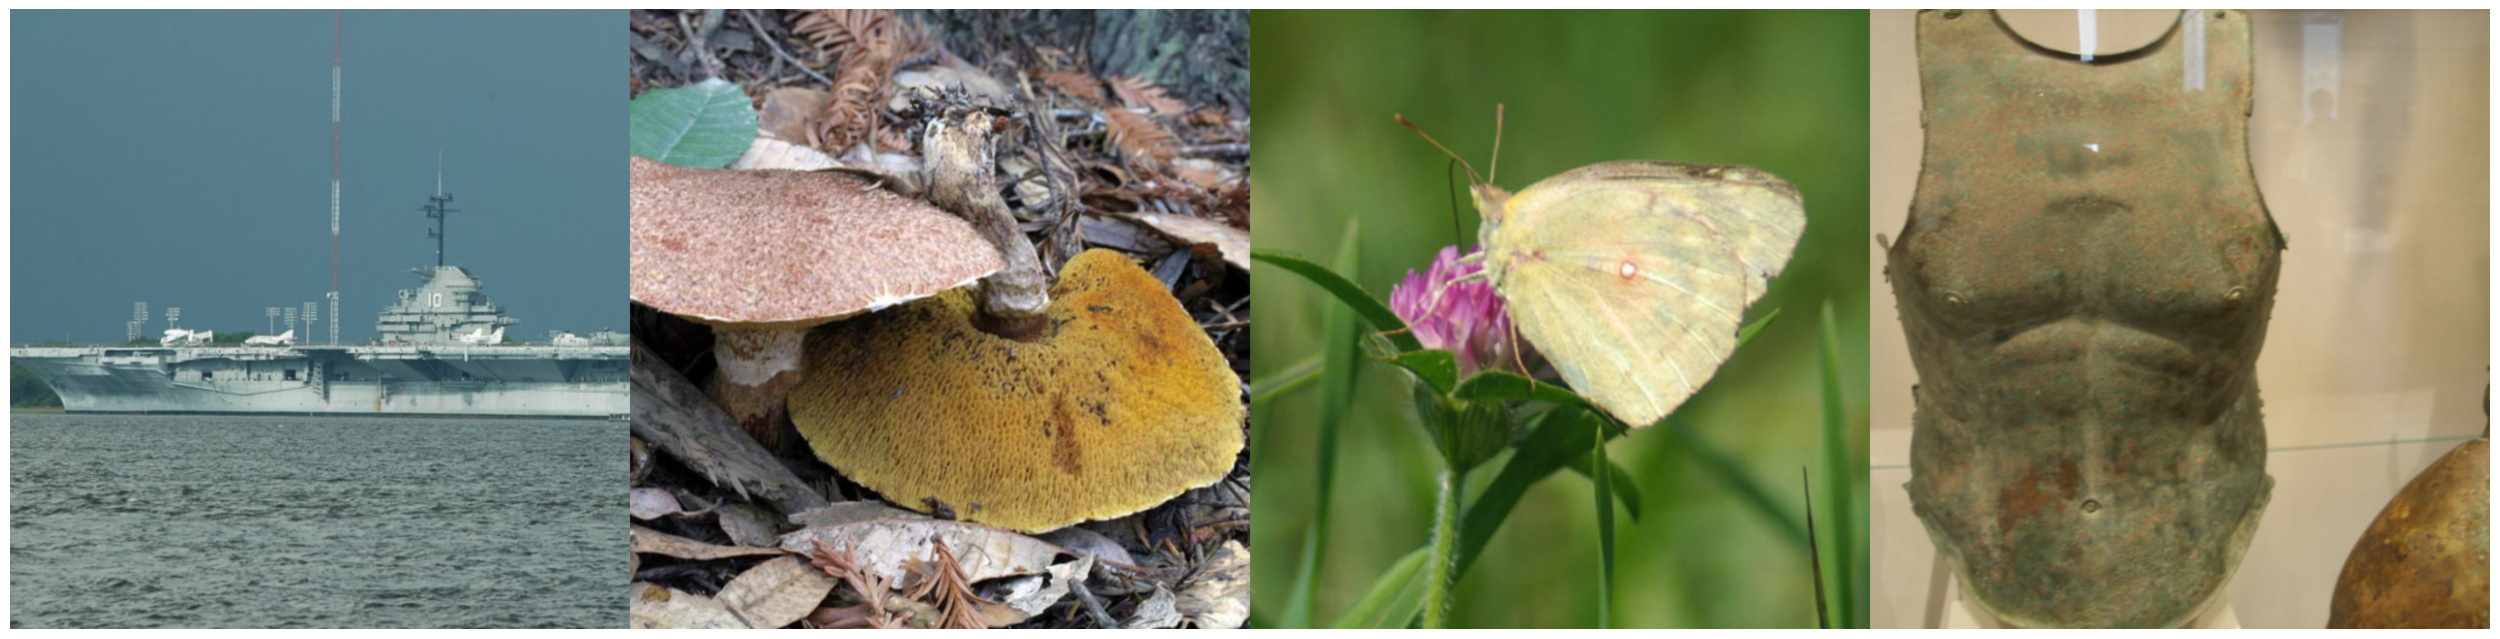

['The image features a large gray warship or aircraft carrier floating in the ocean. There are multiple planes visible on the deck of the ship, indicating it is a military vessel. In addition to the aircraft carrier, there are three boats nearby. One of the boats is positioned close to the aircraft carrier, while the other two are located further away. The ocean scene is set against a blue and gray sky background.', 'Two mushrooms are growing in a lush forest, surrounded by dead leaves and various tree branches.', 'A white butterfly is perched on a purple flower, with its wings spread open. It has two orange spots on its body and a cloudy background.', 'A rusty iron chain armor with the shape of the human torso is placed in a transparent glass box. It has two shoulders and a belt, with the front facing the wall. Next to it, there is an artifact in the shape of a bowl.']


In [8]:
# PREVIEW BATCH
batch = next(data.iterator)
print("ORIG SIZE:", batch['images'].shape)

show_images(batch['images'])

print(batch['captions'])

SCALED SIZE: torch.Size([4, 3, 768, 768])
torch.Size([4, 16, 24, 24])


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.32it/s]


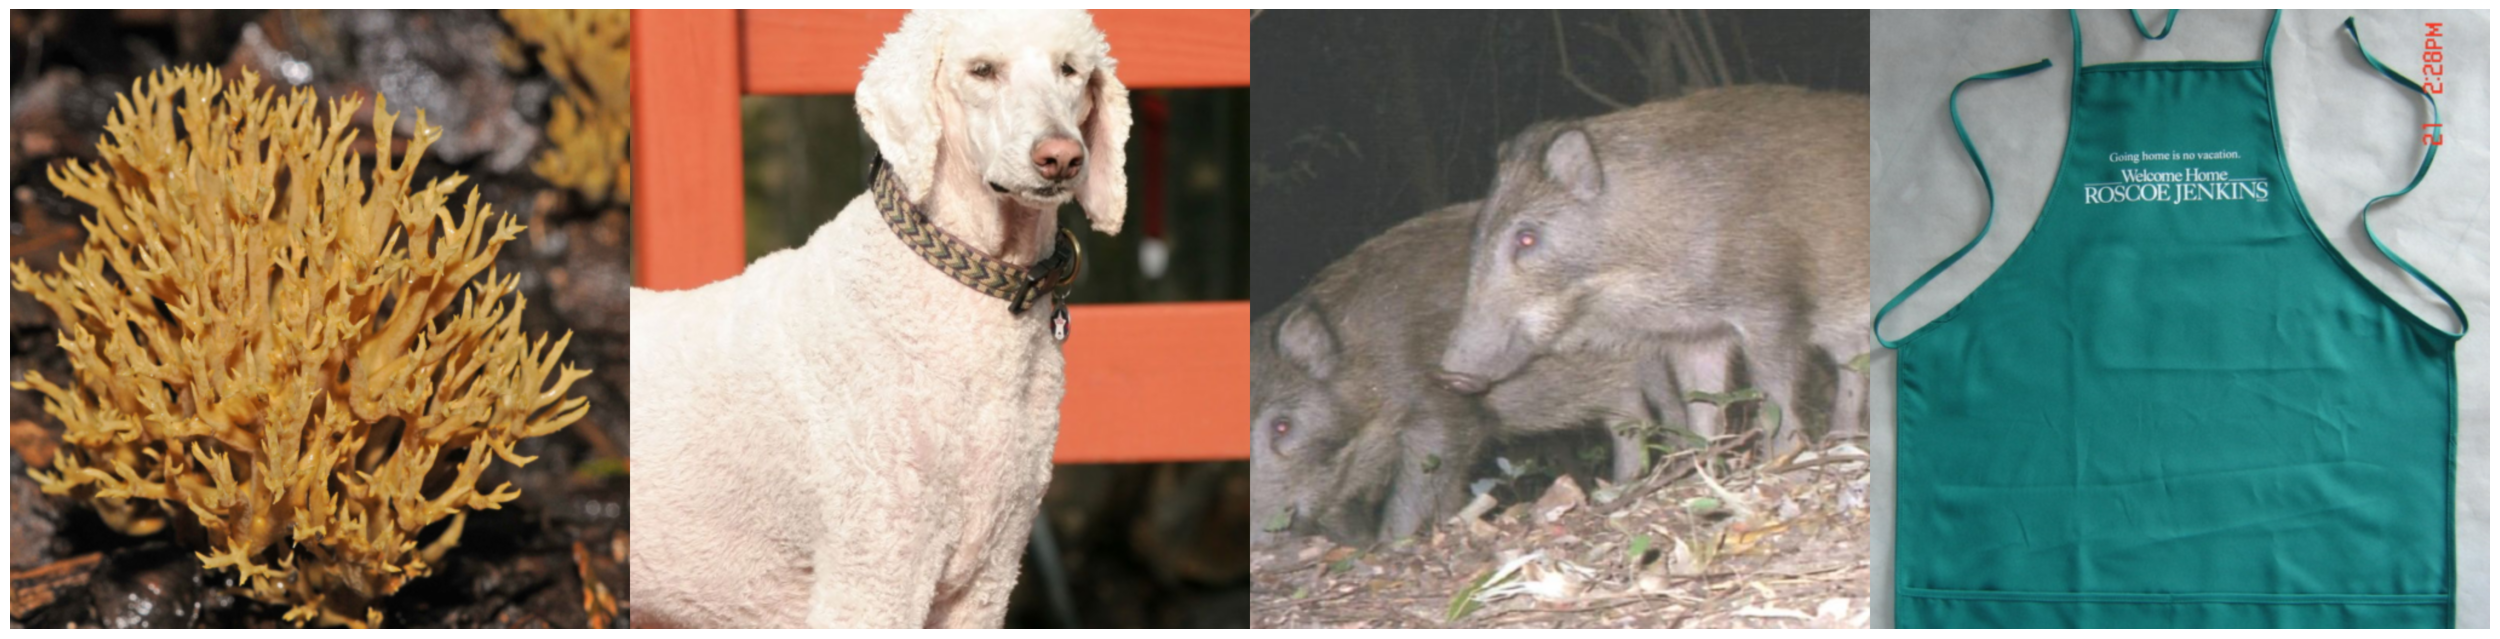

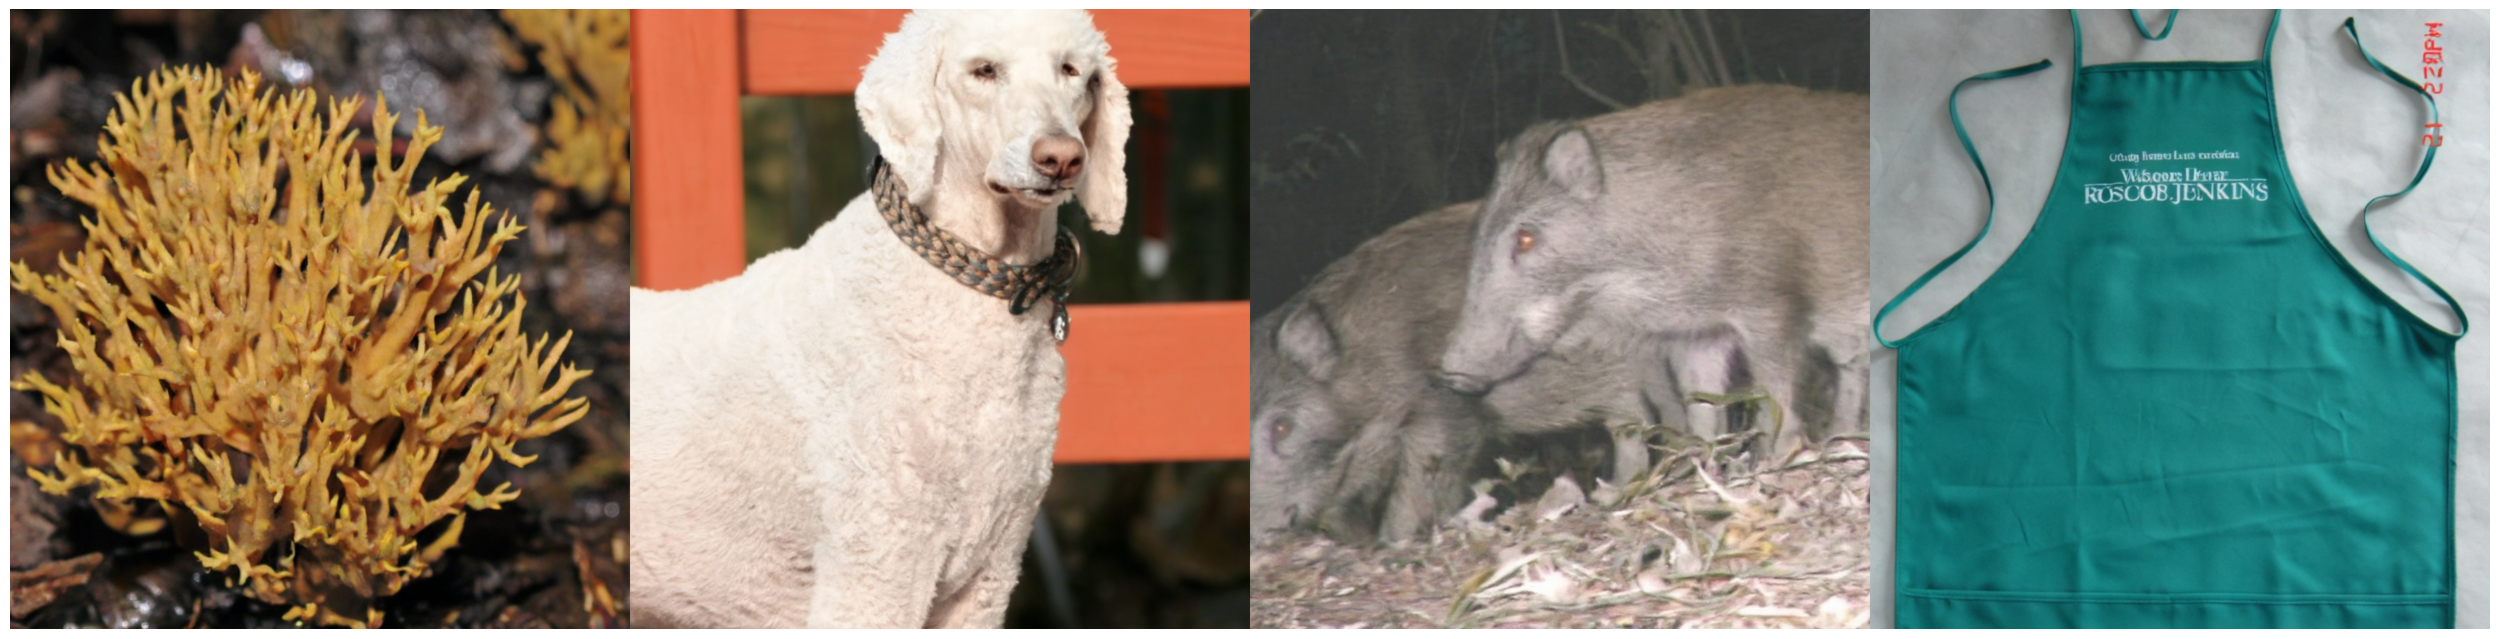

In [10]:
# Stage B Parameters
extras.sampling_configs['cfg'] = 1.1
extras.sampling_configs['shift'] = 1
extras.sampling_configs['timesteps'] = 10
extras.sampling_configs['t_start'] = 1.0

with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.bfloat16):
    # torch.manual_seed(42)
    
    effnet_factor = 3/4
    effnet_height, effnet_width = int(((batch['images'].size(-2)*effnet_factor)//32)*32), int(((batch['images'].size(-1)*effnet_factor)//32)*32)
    scaled_image = torchvision.transforms.functional.resize(batch['images'], (effnet_height, effnet_width), interpolation=torchvision.transforms.InterpolationMode.NEAREST)
    print("SCALED SIZE:", scaled_image.shape)
    
    effnet_latents = models.effnet(extras.effnet_preprocess(scaled_image.to(device)))
    print(effnet_latents.shape)
    
    conditions = core.get_conditions(batch, models, extras, is_eval=True, is_unconditional=False, eval_image_embeds=False)
    unconditions = core.get_conditions(batch, models, extras, is_eval=True, is_unconditional=True, eval_image_embeds=False)    
    conditions['effnet'] = effnet_latents
    unconditions['effnet'] = torch.zeros_like(effnet_latents)

    sampling_b = extras.gdf.sample(
        models.generator, conditions, (batch['images'].size(0), 4, batch['images'].size(-2)//4, batch['images'].size(-1)//4),
        unconditions, device=device, **extras.sampling_configs
    )
    for (sampled_b, _, _) in tqdm(sampling_b, total=extras.sampling_configs['timesteps']):
        sampled_b = sampled_b
    sampled_b = models.stage_a.decode(sampled_b).float()
        
show_images(batch['images'])
show_images(sampled_b)